# Data Preprocessing for Emotion Recognition

**Author**: Suneth (FC211003)  
**Date**: November 2, 2025  
**Purpose**: Preprocess FER2013 dataset for emotion recognition model training

## Pipeline Overview

1. **Load & Filter Classes**: Use only 5 emotions (happy, sad, neutral, angry, surprised)
2. **Quality Filtering**: Remove duplicates, low-quality, over/under-bright images
3. **Balance Classes**: Equal number of images per emotion
4. **Train/Test Split**: 80/20 stratified split
5. **Save**: Export as `.npz` files for training

## 1. Import Libraries

In [15]:
import os
import numpy as np
from PIL import Image
import cv2
from hashlib import md5
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import random

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

## 2. Configuration

In [16]:
# Check current working directory
print(f"Current working directory: {os.getcwd()}\n")

# ========== PATHS ==========
# Use /app paths for Docker container
INPUT_DIR = "/app/data/raw/fer2013/train"
OUTPUT_DIR = "/app/data/processed/FC211003_Suneth"
TRAIN_OUTPUT = os.path.join(OUTPUT_DIR, "train.npz")
VAL_OUTPUT = os.path.join(OUTPUT_DIR, "val.npz")
TEST_OUTPUT = os.path.join(OUTPUT_DIR, "test.npz")

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ========== IMAGE PARAMETERS ==========
TARGET_SIZE = (48, 48)

# ========== CLASS MAPPING ==========
# Map original FER2013 classes to our 5 emotions
CLASS_MAPPING = {
    "happy": "happy",
    "sad": "sad",
    "angry": "angry",
    "neutral": "neutral",
    "surprise": "surprised", 
    # Classes to exclude:
    "disgust": None,
    "fear": None
}

# ========== QUALITY FILTERS ==========
MIN_BRIGHTNESS = 20        # Remove images darker than this
MAX_BRIGHTNESS = 200       # Remove images brighter than this
MIN_CONTRAST = 10          # Remove images with very low contrast

# ========== BALANCING ==========
TARGET_IMAGES_PER_CLASS = 3500  # After balancing, each class will have this many images

# ========== TRAIN/VAL/TEST SPLIT ==========
TEST_SIZE = 0.15           # 15% for testing
VAL_SIZE = 0.15            # 15% for validation 

print("="*60)
print("Configuration Summary")
print("="*60)
print(f"Input Directory  : {INPUT_DIR}")
print(f"Output Directory : {OUTPUT_DIR}")
print(f"\nTarget Classes   : {[k for k, v in CLASS_MAPPING.items() if v is not None]}")
print(f"Images per Class : {TARGET_IMAGES_PER_CLASS}")
print(f"\nData Split")
print(f"   • Training   : 70%")
print(f"   • Validation : 15%")
print(f"   • Testing    : 15%")
print(f"\nQuality Filters")
print(f"   • Brightness range : [{MIN_BRIGHTNESS}, {MAX_BRIGHTNESS}]")
print(f"   • Min contrast     : {MIN_CONTRAST}")
print("="*60)

# Verify input directory exists
if os.path.exists(INPUT_DIR):
    print(f"\nInput directory found")
    print(f"Available classes: {os.listdir(INPUT_DIR)}")
else:
    print(f"\nWARNING: Input directory not found")
    print(f"Path: {INPUT_DIR}")
    print("Please check if the Docker volume is mounted correctly")


Current working directory: /app

Configuration Summary
Input Directory  : /app/data/raw/fer2013/train
Output Directory : /app/data/processed/FC211003_Suneth

Target Classes   : ['happy', 'sad', 'angry', 'neutral', 'surprise']
Images per Class : 3500

Data Split
   • Training   : 70%
   • Validation : 15%
   • Testing    : 15%

Quality Filters
   • Brightness range : [20, 200]
   • Min contrast     : 10

Input directory found
Available classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


## 4. Image Loading & Quality Filtering

This step will:
- Load all images from the 5 selected emotion classes
- Remove duplicate images (hash-based)
- Filter out images that are too bright or too dark
- Filter out images with low contrast
- Store valid images with their labels

**Note**: Face detection removed to increase dataset size

In [17]:
# Storage for processing
all_images = []           # List of numpy arrays
all_labels = []           # List of string labels
seen_hashes = set()       # For duplicate detection

# Statistics
stats = {
    'total_scanned': 0,
    'duplicates': 0,
    'too_bright': 0,
    'too_dark': 0,
    'low_contrast': 0,
    'corrupted': 0,
    'valid': 0,
    'excluded_classes': 0
}

print("="*60)
print("Starting Image Loading & Quality Filtering")
print("="*60)

# Iterate through each class folder
for original_class in tqdm(os.listdir(INPUT_DIR), desc="Processing Classes"):
    class_path = os.path.join(INPUT_DIR, original_class)
    
    if not os.path.isdir(class_path):
        continue
    
    # Check if this class should be included
    mapped_class = CLASS_MAPPING.get(original_class.lower())
    
    if mapped_class is None:
        excluded_count = len(os.listdir(class_path))
        stats['excluded_classes'] += excluded_count
        print(f"Skipping '{original_class}' - {excluded_count} images excluded")
        continue
    
    # Process images in this class
    file_list = os.listdir(class_path)
    class_valid = 0
    
    for file_name in tqdm(file_list, desc=f"  {original_class}", leave=False):
        fpath = os.path.join(class_path, file_name)
        stats['total_scanned'] += 1
        
        try:
            # ===== STEP 1: Check for duplicates =====
            with open(fpath, 'rb') as f:
                img_hash = md5(f.read()).hexdigest()
            
            if img_hash in seen_hashes:
                stats['duplicates'] += 1
                continue
            
            seen_hashes.add(img_hash)
            
            # ===== STEP 2: Load and convert to grayscale =====
            img = Image.open(fpath).convert("L")
            img_np = np.array(img)
            
            # ===== STEP 3: Check brightness =====
            brightness = float(np.mean(img_np))
            
            if brightness < MIN_BRIGHTNESS:
                stats['too_dark'] += 1
                continue
            
            if brightness > MAX_BRIGHTNESS:
                stats['too_bright'] += 1
                continue
            
            # ===== STEP 4: Check contrast =====
            contrast = float(np.std(img_np))
            
            if contrast < MIN_CONTRAST:
                stats['low_contrast'] += 1
                continue
            
            # ===== STEP 5: Resize to target size =====
            img_resized = img.resize(TARGET_SIZE, Image.BILINEAR)
            
            # ===== STEP 6: Normalize to [0, 1] =====
            img_array = np.array(img_resized, dtype=np.float32) / 255.0
            
            # ===== STEP 7: Add channel dimension (48, 48, 1) =====
            img_array = np.expand_dims(img_array, axis=-1)
            
            # ===== STEP 8: Store valid image =====
            all_images.append(img_array)
            all_labels.append(mapped_class)
            stats['valid'] += 1
            class_valid += 1
            
        except Exception as e:
            stats['corrupted'] += 1
            continue
    
    print(f"   • {original_class:12s} : {class_valid} valid images")

print("\n" + "="*60)
print("Image Loading Complete")
print("="*60)
print("Filtering Statistics")
print(f"   • Total scanned      : {stats['total_scanned']}")
print(f"   • Excluded classes   : {stats['excluded_classes']}")
print(f"   • Duplicates removed : {stats['duplicates']}")
print(f"   • Too bright         : {stats['too_bright']}")
print(f"   • Too dark           : {stats['too_dark']}")
print(f"   • Low contrast       : {stats['low_contrast']}")
print(f"   • Corrupted files    : {stats['corrupted']}")
print(f"   • Valid images       : {stats['valid']}")
print("="*60)


Starting Image Loading & Quality Filtering


Processing Classes:   0%|          | 0/7 [00:00<?, ?it/s]

  angry:   0%|          | 0/3995 [00:00<?, ?it/s]

   • angry        : 3809 valid images
Skipping 'disgust' - 436 images excluded
Skipping 'fear' - 4097 images excluded


  happy:   0%|          | 0/7215 [00:00<?, ?it/s]

   • happy        : 6977 valid images


  neutral:   0%|          | 0/4965 [00:00<?, ?it/s]

   • neutral      : 4829 valid images


  sad:   0%|          | 0/4830 [00:00<?, ?it/s]

   • sad          : 4685 valid images


  surprise:   0%|          | 0/3171 [00:00<?, ?it/s]

   • surprise     : 2588 valid images

Image Loading Complete
Filtering Statistics
   • Total scanned      : 24176
   • Excluded classes   : 4533
   • Duplicates removed : 968
   • Too bright         : 310
   • Too dark           : 9
   • Low contrast       : 1
   • Corrupted files    : 0
   • Valid images       : 22888


## 5. Class Distribution (Before Balancing)

Class Distribution BEFORE Balancing
   • angry        : 3,809
   • happy        : 6,977
   • neutral      : 4,829
   • sad          : 4,685
   • surprised    : 2,588


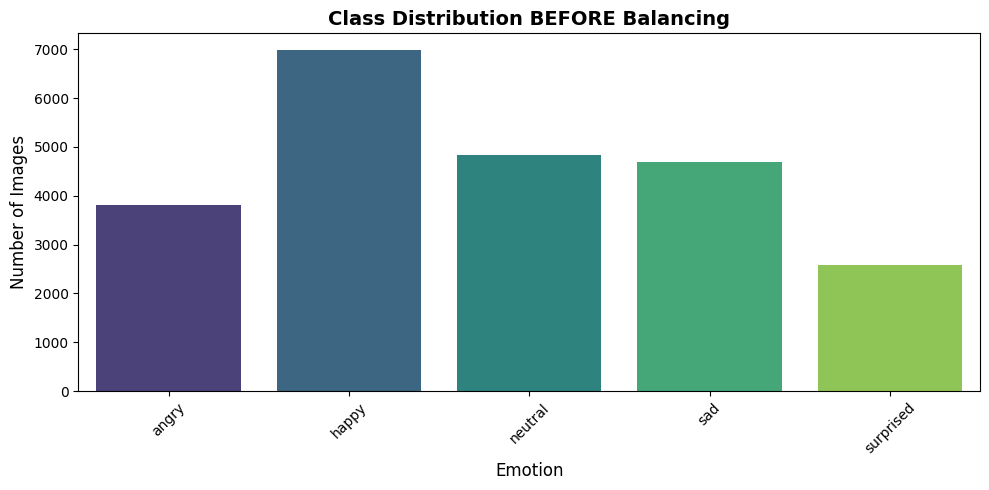

In [18]:
# Count images per class
class_counts_before = Counter(all_labels)

print("="*60)
print("Class Distribution BEFORE Balancing")
print("="*60)
for emotion, count in sorted(class_counts_before.items()):
    print(f"   • {emotion:12s} : {count:,}")
print("="*60)

# Visualize
plt.figure(figsize=(10, 5))
emotions = list(class_counts_before.keys())
counts = list(class_counts_before.values())

sns.barplot(x=emotions, y=counts, palette='viridis')
plt.title('Class Distribution BEFORE Balancing', fontsize=14, fontweight='bold')
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 6. Class Balancing

Balance the dataset by randomly sampling equal numbers from each class.

In [19]:
print("="*60)
print("Class Balancing")
print("="*60)
print(f"Target: {TARGET_IMAGES_PER_CLASS} images per class\n")

# Group images by class
images_by_class = {emotion: [] for emotion in set(all_labels)}

for img, label in zip(all_images, all_labels):
    images_by_class[label].append(img)

# Balance each class
balanced_images = []
balanced_labels = []

for emotion, images in images_by_class.items():
    n_available = len(images)
    
    if n_available >= TARGET_IMAGES_PER_CLASS:
        # Random undersample
        selected_indices = random.sample(range(n_available), TARGET_IMAGES_PER_CLASS)
        selected_images = [images[i] for i in selected_indices]
        print(f"   • {emotion:12s} : {n_available:,} → {TARGET_IMAGES_PER_CLASS:,} (undersampled)")
    else:
        # Use all available images (if not enough)
        selected_images = images
        print(f"   • {emotion:12s} : {n_available:,} (keeping all)")
    
    balanced_images.extend(selected_images)
    balanced_labels.extend([emotion] * len(selected_images))

# Convert to numpy arrays
X = np.array(balanced_images, dtype=np.float32)
y_labels = np.array(balanced_labels)

print("\n" + "="*60)
print("Balancing Complete")
print("="*60)
print(f"Total balanced samples: {len(X):,}\n")

# Count after balancing
class_counts_after = Counter(y_labels)
print("Class Distribution AFTER Balancing")
for emotion, count in sorted(class_counts_after.items()):
    print(f"   • {emotion:12s} : {count:,}")
print("="*60)


Class Balancing
Target: 3500 images per class

   • sad          : 4,685 → 3,500 (undersampled)
   • neutral      : 4,829 → 3,500 (undersampled)
   • surprised    : 2,588 (keeping all)
   • happy        : 6,977 → 3,500 (undersampled)
   • angry        : 3,809 → 3,500 (undersampled)

Balancing Complete
Total balanced samples: 16,588

Class Distribution AFTER Balancing
   • angry        : 3,500
   • happy        : 3,500
   • neutral      : 3,500
   • sad          : 3,500
   • surprised    : 2,588

Balancing Complete
Total balanced samples: 16,588

Class Distribution AFTER Balancing
   • angry        : 3,500
   • happy        : 3,500
   • neutral      : 3,500
   • sad          : 3,500
   • surprised    : 2,588


## 7. Visualize Balanced Distribution

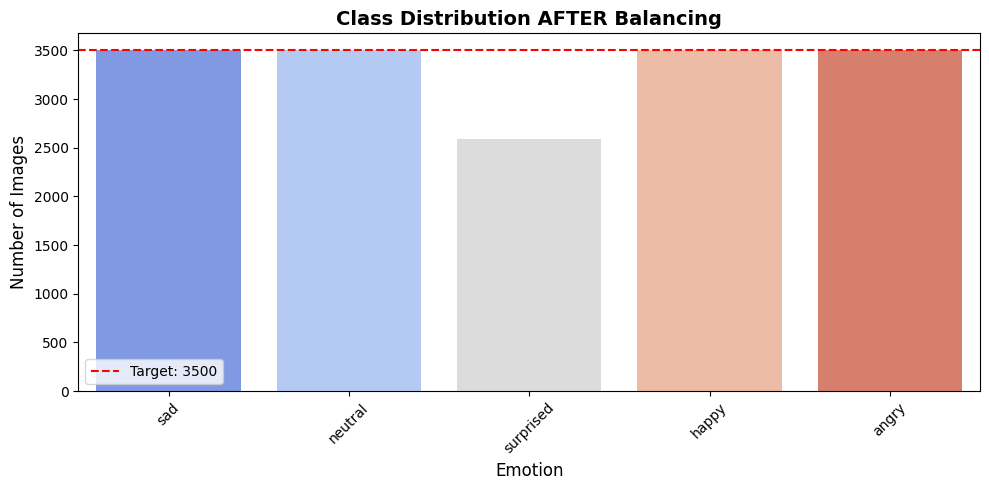

In [20]:
plt.figure(figsize=(10, 5))
emotions = list(class_counts_after.keys())
counts = list(class_counts_after.values())

sns.barplot(x=emotions, y=counts, palette='coolwarm')
plt.title('Class Distribution AFTER Balancing', fontsize=14, fontweight='bold')
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.axhline(y=TARGET_IMAGES_PER_CLASS, color='red', linestyle='--', label=f'Target: {TARGET_IMAGES_PER_CLASS}')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 8. Encode Labels

Convert string labels to one-hot encoded format.

In [21]:
print("="*60)
print("Label Encoding")
print("="*60)

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y_labels)

# One-hot encoding
y_onehot = to_categorical(y_encoded)

print("Label Mapping")
for i, emotion in enumerate(le.classes_):
    print(f"   • {i} → {emotion}")

print(f"\nData Shapes")
print(f"   • X : {X.shape}")
print(f"   • y : {y_onehot.shape}")
print("="*60)


Label Encoding
Label Mapping
   • 0 → angry
   • 1 → happy
   • 2 → neutral
   • 3 → sad
   • 4 → surprised

Data Shapes
   • X : (16588, 48, 48, 1)
   • y : (16588, 5)


## 9. Train/Val/Test Split

Split the dataset into 70% training, 15% validation, and 15% testing with stratification.

In [22]:
print("="*60)
print("Train/Validation/Test Split")
print("="*60)

# First split: separate test set (15%)
X_temp, X_test, y_temp, y_test, labels_temp, labels_test = train_test_split(
    X, y_onehot, y_labels,
    test_size=TEST_SIZE,
    stratify=y_labels,
    random_state=42
)

# Second split: separate validation from remaining data
# VAL_SIZE / (1 - TEST_SIZE) = 0.15 / 0.85 ≈ 0.176 to get 15% of original data
val_size_adjusted = VAL_SIZE / (1 - TEST_SIZE)

X_train, X_val, y_train, y_val, labels_train, labels_val = train_test_split(
    X_temp, y_temp, labels_temp,
    test_size=val_size_adjusted,
    stratify=labels_temp,
    random_state=42
)

print("Dataset Split Summary")
print(f"   • Training   : {X_train.shape} ({len(X_train)/len(X)*100:.1f}%)")
print(f"   • Validation : {X_val.shape} ({len(X_val)/len(X)*100:.1f}%)")
print(f"   • Testing    : {X_test.shape} ({len(X_test)/len(X)*100:.1f}%)")

# Verify class distribution
train_counts = Counter(labels_train)
val_counts = Counter(labels_val)
test_counts = Counter(labels_test)

print(f"\nTraining Set Distribution")
for emotion, count in sorted(train_counts.items()):
    print(f"   • {emotion:12s} : {count:,}")

print(f"\nValidation Set Distribution")
for emotion, count in sorted(val_counts.items()):
    print(f"   • {emotion:12s} : {count:,}")

print(f"\nTesting Set Distribution")
for emotion, count in sorted(test_counts.items()):
    print(f"   • {emotion:12s} : {count:,}")
print("="*60)


Train/Validation/Test Split
Dataset Split Summary
   • Training   : (11610, 48, 48, 1) (70.0%)
   • Validation : (2489, 48, 48, 1) (15.0%)
   • Testing    : (2489, 48, 48, 1) (15.0%)

Training Set Distribution
   • angry        : 2,450
   • happy        : 2,450
   • neutral      : 2,450
   • sad          : 2,450
   • surprised    : 1,810

Validation Set Distribution
   • angry        : 525
   • happy        : 525
   • neutral      : 525
   • sad          : 525
   • surprised    : 389

Testing Set Distribution
   • angry        : 525
   • happy        : 525
   • neutral      : 525
   • sad          : 525
   • surprised    : 389
Dataset Split Summary
   • Training   : (11610, 48, 48, 1) (70.0%)
   • Validation : (2489, 48, 48, 1) (15.0%)
   • Testing    : (2489, 48, 48, 1) (15.0%)

Training Set Distribution
   • angry        : 2,450
   • happy        : 2,450
   • neutral      : 2,450
   • sad          : 2,450
   • surprised    : 1,810

Validation Set Distribution
   • angry        : 525


## 10. Visualize Sample Images

Display a few samples from the training set to verify preprocessing.

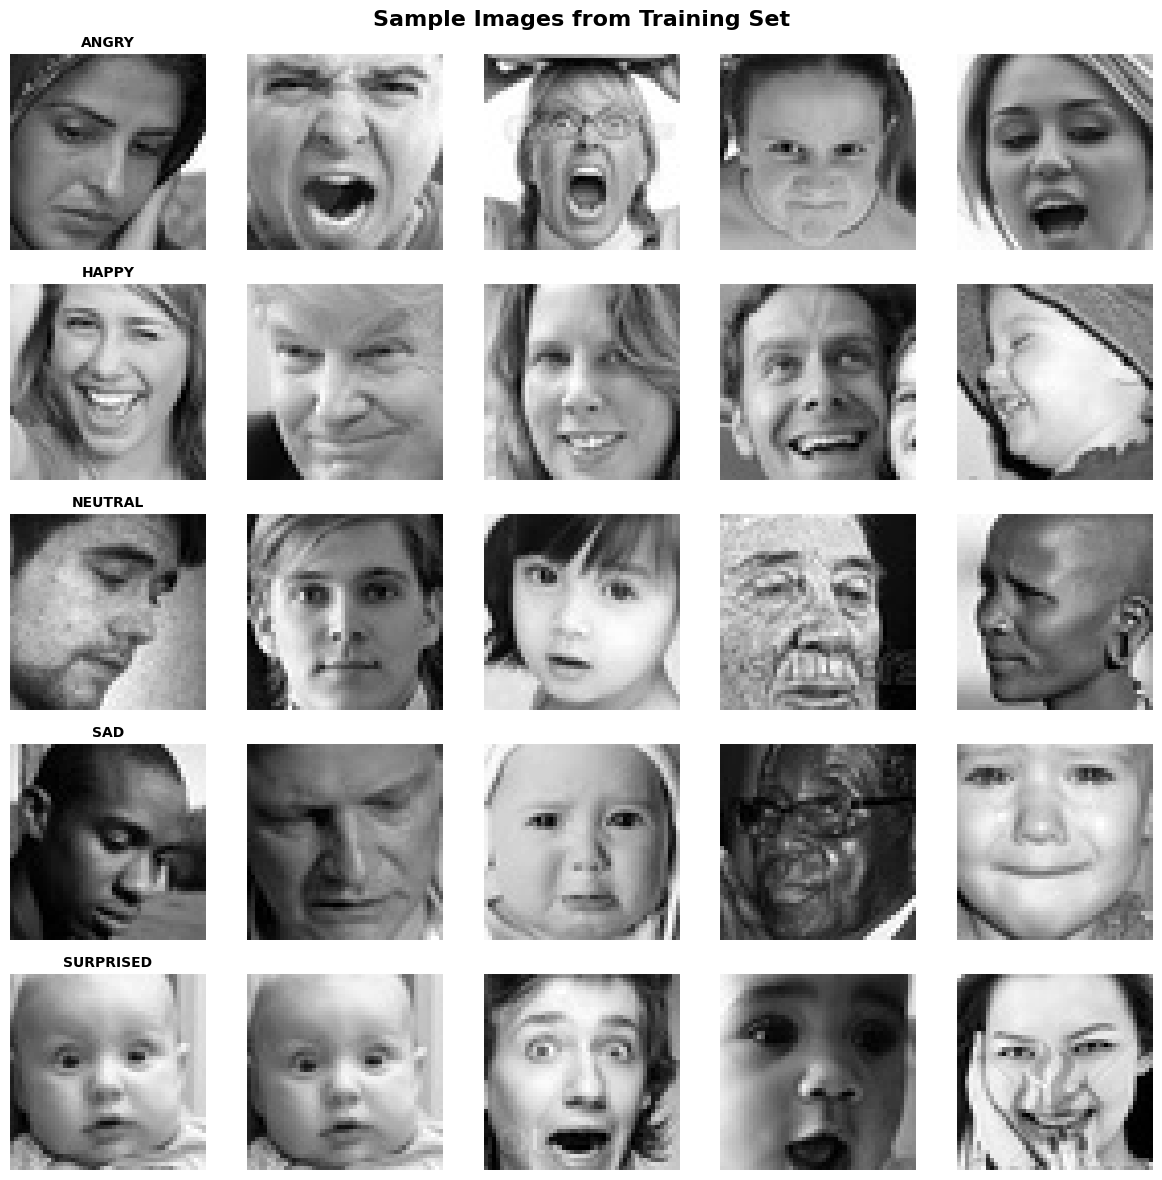

In [23]:
# Display sample images from each class
fig, axes = plt.subplots(5, 5, figsize=(12, 12))
fig.suptitle('Sample Images from Training Set', fontsize=16, fontweight='bold')

for i, emotion in enumerate(sorted(le.classes_)):
    # Find indices of this emotion in training set
    emotion_indices = [idx for idx, lbl in enumerate(labels_train) if lbl == emotion]
    
    # Select 5 random samples
    sample_indices = random.sample(emotion_indices, min(5, len(emotion_indices)))
    
    for j, idx in enumerate(sample_indices):
        axes[i, j].imshow(X_train[idx].squeeze(), cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(emotion.upper(), fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## 11. Save Processed Datasets

Save training, validation, and testing sets as compressed `.npz` files.

In [26]:
print("Saving Processed Datasets")
print("="*60)

# Save training set
np.savez_compressed(
    TRAIN_OUTPUT,
    X=X_train,
    y=y_train,
    label_names=le.classes_
)
print(f"Training Set")
print(f"   • Path  : {TRAIN_OUTPUT}")
print(f"   • Shape : {X_train.shape}")

# Save validation set
np.savez_compressed(
    VAL_OUTPUT,
    X=X_val,
    y=y_val,
    label_names=le.classes_
)
print(f"\nValidation Set")
print(f"   • Path  : {VAL_OUTPUT}")
print(f"   • Shape : {X_val.shape}")

# Save testing set
np.savez_compressed(
    TEST_OUTPUT,
    X=X_test,
    y=y_test,
    label_names=le.classes_
)
print(f"\nTesting Set")
print(f"   • Path  : {TEST_OUTPUT}")
print(f"   • Shape : {X_test.shape}")


Saving Processed Datasets
Training Set
   • Path  : /app/data/processed/FC211003_Suneth/train.npz
   • Shape : (11610, 48, 48, 1)
Training Set
   • Path  : /app/data/processed/FC211003_Suneth/train.npz
   • Shape : (11610, 48, 48, 1)

Validation Set
   • Path  : /app/data/processed/FC211003_Suneth/val.npz
   • Shape : (2489, 48, 48, 1)

Validation Set
   • Path  : /app/data/processed/FC211003_Suneth/val.npz
   • Shape : (2489, 48, 48, 1)

Testing Set
   • Path  : /app/data/processed/FC211003_Suneth/test.npz
   • Shape : (2489, 48, 48, 1)

Testing Set
   • Path  : /app/data/processed/FC211003_Suneth/test.npz
   • Shape : (2489, 48, 48, 1)


## 12. Summary Statistics

In [28]:
print("="*60)
print("FINAL PREPROCESSING SUMMARY")
print("="*60)
print(f"Target Emotions : {len(le.classes_)} classes")
print(f"   • {', '.join(sorted(le.classes_))}")

print(f"\nDataset Statistics")
print(f"   • Total processed : {len(X):,}")
print(f"   • Training        : {len(X_train):,} ({(len(X_train)/len(X)*100):.1f}%)")
print(f"   • Validation      : {len(X_val):,} ({(len(X_val)/len(X)*100):.1f}%)")
print(f"   • Testing         : {len(X_test):,} ({(len(X_test)/len(X)*100):.1f}%)")

print(f"\nImage Properties")
print(f"   • Size         : {TARGET_SIZE}")
print(f"   • Channels     : 1 (grayscale)")
print(f"   • Value range  : [0.0, 1.0] (normalized)")

print(f"\nQuality Filters Applied")
print(f"   • Brightness   : [{MIN_BRIGHTNESS}, {MAX_BRIGHTNESS}]")
print(f"   • Min contrast : {MIN_CONTRAST}")
print(f"   • Duplicates   : MD5 hash-based removal")
print(f"   • Face detect  : Disabled (maximize dataset size)")

print(f"\nClass Balancing Summary")
print(f"Target per class: {TARGET_IMAGES_PER_CLASS}")
for emotion in sorted(le.classes_):
    train_count = train_counts[emotion]
    val_count = val_counts[emotion]
    test_count = test_counts[emotion]
    total = train_count + val_count + test_count
    print(f"   • {emotion:12s} : {total:,} ({train_count:,} train + {val_count:,} val + {test_count:,} test)")

print(f"\nOutput Files")
print(f"   • {TRAIN_OUTPUT}")
print(f"   • {VAL_OUTPUT}")
print(f"   • {TEST_OUTPUT}")

print("\n" + "="*60)
print("Ready for model training")
print("="*60)


FINAL PREPROCESSING SUMMARY
Target Emotions : 5 classes
   • angry, happy, neutral, sad, surprised

Dataset Statistics
   • Total processed : 16,588
   • Training        : 11,610 (70.0%)
   • Validation      : 2,489 (15.0%)
   • Testing         : 2,489 (15.0%)

Image Properties
   • Size         : (48, 48)
   • Channels     : 1 (grayscale)
   • Value range  : [0.0, 1.0] (normalized)

Quality Filters Applied
   • Brightness   : [20, 200]
   • Min contrast : 10
   • Duplicates   : MD5 hash-based removal
   • Face detect  : Disabled (maximize dataset size)

Class Balancing Summary
Target per class: 3500
   • angry        : 3,500 (2,450 train + 525 val + 525 test)
   • happy        : 3,500 (2,450 train + 525 val + 525 test)
   • neutral      : 3,500 (2,450 train + 525 val + 525 test)
   • sad          : 3,500 (2,450 train + 525 val + 525 test)
   • surprised    : 2,588 (1,810 train + 389 val + 389 test)

Output Files
   • /app/data/processed/FC211003_Suneth/train.npz
   • /app/data/process